# Задание 6: Рекуррентные нейронные сети (RNNs)

Это задание адаптиповано из Deep NLP Course at ABBYY (https://github.com/DanAnastasyev/DeepNLP-Course) с разрешения автора - Даниила Анастасьева. Спасибо ему огромное!

In [0]:
!pip3 -qq install --user torch==0.4.1
!pip3 -qq install --user bokeh==0.13.0
!pip3 -qq install --user gensim==3.6.0
!pip3 -qq install --user nltk
!pip3 -qq install --user scikit-learn==0.20.2

     |████████████████████████████████| 519.5MB 47kB/s 
ERROR: torchvision 0.3.0 has requirement torch>=1.1.0, but you'll have torch 0.4.1 which is incompatible.
ERROR: fastai 1.0.55 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
     |████████████████████████████████| 16.0MB 1.3MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
     |████████████████████████████████| 5.4MB 1.3MB/s 


In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    device = torch.device("cuda")
else:
    from torch import FloatTensor, LongTensor
    device = torch.device("cpu")
np.random.seed(42)

# Рекуррентные нейронные сети (RNNs)

## POS Tagging

Мы рассмотрим применение рекуррентных сетей к задаче sequence labeling (последняя картинка).

![RNN types](http://karpathy.github.io/assets/rnn/diags.jpeg)

*From [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*

Самые популярные примеры для такой постановки задачи - Part-of-Speech Tagging и Named Entity Recognition.

Мы порешаем сейчас POS Tagging для английского.

Будем работать с таким набором тегов:
- ADJ - adjective (new, good, high, ...)
- ADP - adposition (on, of, at, ...)
- ADV - adverb (really, already, still, ...)
- CONJ - conjunction (and, or, but, ...)
- DET - determiner, article (the, a, some, ...)
- NOUN - noun (year, home, costs, ...)
- NUM - numeral (twenty-four, fourth, 1991, ...)
- PRT - particle (at, on, out, ...)
- PRON - pronoun (he, their, her, ...)
- VERB - verb (is, say, told, ...)
- . - punctuation marks (. , ;)
- X - other (ersatz, esprit, dunno, ...)

Скачаем данные:

In [2]:
import nltk
from sklearn.model_selection import train_test_split

nltk.download('brown')
nltk.download('universal_tagset')

data = nltk.corpus.brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [3]:
print(type(data[0]))

<class 'list'>


In [4]:
print([x for x,y in data[0]])
print(data[0])

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']
[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')]


In [5]:
only_sents = nltk.corpus.brown.sents()
print(only_sents[0])

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']


In [6]:
import os
import numpy as np
import random
def get_OneHot_by_index(index, num_tokens):
    vector = [0]*num_tokens
    vector[index] = 1
    return torch.tensor(vector)

class StanfordTreeBank:
    '''
    Wrapper for accessing Stanford Tree Bank Dataset
    https://nlp.stanford.edu/sentiment/treebank.html
    
    Parses dataset, gives each token and index and provides lookups
    from string token to index and back
    
    Allows to generate random context with sampling strategy described in
    word2vec paper:
    https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
    '''
    def __init__(self):
        self.index_by_token = {} # map of string -> token index
        self.token_by_index = []

        self.sentences_by_token = {}
        self.sentences = []

        self.token_freq = {}
        
        self.token_reject_by_index = None

    def load_dataset(self, folder):
        filename = os.path.join(folder, "datasetSentences.txt")

        with open(filename, "r", encoding="latin1") as f:
            l = f.readline() # skip the first line
            
            for l in f:
                splitted_line = l.strip().split()
                words = [w.lower() for w in splitted_line[1:]] # First one is a number
                    
                self.sentences.append(words)
                for i, word in enumerate(words):
                    if word in self.token_freq:
                        self.token_freq[word] +=1
                        self.sentences_by_token[word].append((len(self.sentences) - 1, i))
                    else:
                        index = len(self.token_by_index)
                        self.token_freq[word] = 1
                        self.index_by_token[word] = index
                        self.token_by_index.append(word)
                        self.sentences_by_token[word] = [(len(self.sentences) - 1, i)] 
        self.compute_token_prob()
    
    def init_dataset(self, data):    
       
        for words in data:
              words = [w.lower() for w in words] # First one is a number

              self.sentences.append(words)
              for i, word in enumerate(words):
                  if word in self.token_freq:
                      self.token_freq[word] +=1
                      self.sentences_by_token[word].append((len(self.sentences) - 1, i))
                  else:
                      index = len(self.token_by_index)
                      self.token_freq[word] = 1
                      self.index_by_token[word] = index
                      self.token_by_index.append(word)
                      self.sentences_by_token[word] = [(len(self.sentences) - 1, i)] 
        self.compute_token_prob()

    def compute_token_prob(self):
        words_count = np.array([self.token_freq[token] for token in self.token_by_index])
        words_freq = words_count / np.sum(words_count)
        
        # Following sampling strategy from word2vec paper
        self.token_reject_by_index = 1- np.sqrt(1e-5/words_freq)
    
    def check_reject(self, word):
        return np.random.rand() > self.token_reject_by_index[self.index_by_token[word]]
        
    def get_random_context(self, context_length=5):
        """
        Returns tuple of center word and list of context words
        """
        sentence_sampled = []
        while len(sentence_sampled) <= 2:
            sentence_index = np.random.randint(len(self.sentences)) 
            sentence = self.sentences[sentence_index]
            sentence_sampled = [word for word in sentence if self.check_reject(word)]
    
        center_word_index = np.random.randint(len(sentence_sampled))
        
        words_before = sentence_sampled[max(center_word_index - context_length//2,0):center_word_index]
        words_after = sentence_sampled[center_word_index+1: center_word_index+1+context_length//2]
        
        return sentence_sampled[center_word_index], words_before+words_after
    
    def num_tokens(self):
        return len(self.token_by_index)
     
    def get_OneHot_by_token(self, token):
        return get_OneHot_by_index(self.index_by_token[token], self.num_tokens())
    
    def find_sentence_with_token(self, token, sentence_index, context_length = 5):
        for i, x in enumerate(self.sentences_by_token[token]):
            if sentence_index == x[0]:
                sentence = [word for word in self.sentences[sentence_index] \
                                if self.check_reject(word)]
                begin = max(x[1] - context_length//2, 0)
                end = min(x[1] + context_length//2, len(sentence))
                sequence = sentence[:begin] + sentence[end+1:]
                if sequence != []:
                    return random.choice(sequence)
                break
        return None

    def get_random_out_context(self, token, num_negatives_samples, context_length = 5):
        result = []
        while len(result) < num_negatives_samples:
            sentence_index = np.random.randint(len(self.sentences))
            if token in self.sentences[sentence_index]:
              chosen_token = self.find_sentence_with_token(token, sentence_index, context_length)
            else:
              chosen_token = None
            if chosen_token != None:
                result.append(chosen_token)
            else:
                while True:
                    chosen_token = random.choice(self.sentences[sentence_index])
                    if self.check_reject(chosen_token):
                        result.append(chosen_token)
                        break
        return result
    
StandfordData = StanfordTreeBank()
StandfordData.init_dataset(only_sents)

print("Num tokens:", StandfordData.num_tokens())
print("Num sentences:", len(StandfordData.sentences))
for i in range(5):
    center_word, other_words = StandfordData.get_random_context(5)
    print(center_word, other_words)
    out_context = StandfordData.get_random_out_context(center_word, 5, 5)
    print(out_context)

Num tokens: 49815
Num sentences: 57340
village ['plumber', 'catatonia']
['arizona', 'its', 'mama', 'skies', 'horse']
shirt ['jackboots', 'peasant']
['leg', 'murray', '1298', 'legendary', '30-30']
coastal ['marine', 'life']
['sewage', 'outcome', 'immortal', 'franks', 'twenty-five']
dissatisfied ['totally', 'upper']
['thus', 'coltsman', 'theirs', 'infant', '168']
undressing ['painter', 'nude']
['affirmed', 'less', 'moral', 'reliable', 'you']


In [7]:
from torch.utils.data import Dataset

num_negative_samples = 10

class Word2VecNegativeSampling(Dataset):
    '''
    PyTorch Dataset for Word2Vec with Negative Sampling.
    Accepts StanfordTreebank as data and is able to generate dataset based on
    a number of random contexts
    '''
    def __init__(self, data, num_negative_samples, num_contexts=30000):
        '''
        Initializes Word2VecNegativeSampling, but doesn't generate the samples yet
        (for that, use generate_dataset)
        Arguments:
        data - StanfordTreebank instace
        num_negative_samples - number of negative samples to generate in addition to a positive one
        num_contexts - number of random contexts to use when generating a dataset
        '''
        
        # TODO: Implement what you need for other methods!
        self.num_contexts = num_contexts
        self.data = data
        self.num_negative_samples = num_negative_samples
        self.dataset = []
        
    def generate_dataset(self):
        '''
        Generates dataset samples from random contexts
        Note: there will be more samples than contexts because every context
        can generate more than one sample
        '''
        # TODO: Implement generating the dataset
        # You should sample num_contexts contexts from the data and turn them into samples
        # Note you will have several samples from one context
        del self.dataset
        self.dataset = []
        center, contexts = 0, 0
        for i in range(self.num_contexts):
            del center, contexts
            center, contexts = self.data.get_random_context()
            #print(center, contexts)
            for context in contexts:
                self.dataset.append((center, [context]+self.data.get_random_out_context(center, \
                                    self.num_negative_samples)))
    def __len__(self):
        '''
        Returns total number of samples
        '''
        # TODO: Return the number of samples
        return len(self.dataset)
    
    def __getitem__(self, index):
        '''
        Returns i-th sample
        
        Return values:
        input_vector - index of the input word (not torch.Tensor!)
        output_indices - torch.Tensor of indices of the target words. Should be 1+num_negative_samples.
        output_target - torch.Tensor with float targets for the training. Should be the same size as output_indices
                        and have 1 for the context word and 0 everywhere else
        '''
        # TODO: Generate tuple of 3 return arguments for i-th sample
        center, words = self.dataset[index]
        return self.data.index_by_token[center], torch.tensor([self.data.index_by_token[x]\
                for x in words]), torch.tensor([1.]+[0.]*self.num_negative_samples)
    
dataset = Word2VecNegativeSampling(StandfordData, num_negative_samples, 10)
dataset.generate_dataset()
input_vector, output_indices, output_target = dataset[0]

print("Sample - input: %s, output indices: %s, output target: %s" % (int(input_vector), output_indices, output_target)) # target should be able to convert to int
assert isinstance(output_indices, torch.Tensor)
assert output_indices.shape[0] == num_negative_samples+1

assert isinstance(output_target, torch.Tensor)
assert output_target.shape[0] == num_negative_samples+1
assert torch.sum(output_target) == 1.0

Sample - input: 880, output indices: tensor([ 1391,  4938,  9997, 32069,   406,  2661,  6710,   191,  5337, 45329,
          471]), output target: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [8]:
# Create the usual PyTorch structures
dataset = Word2VecNegativeSampling(StandfordData, num_negative_samples, 30000)
dataset.generate_dataset()

# As before, we'll be training very small word vectors!
wordvec_dim = 100

class Word2VecNegativeSamples(nn.Module):
    def __init__(self, num_tokens, wordvec_dim):
        super(Word2VecNegativeSamples, self).__init__()
        self.input = nn.Linear(num_tokens, wordvec_dim, bias=False)
        self.output = nn.Linear(wordvec_dim, num_tokens, bias=False)
        self.wordvec_dim = wordvec_dim
        
    def forward(self, input_index_batch, output_indices_batch):
        '''
        Implements forward pass with negative sampling
        
        Arguments:
        input_index_batch - Tensor of ints, shape: (batch_size, ), indices of input words in the batch
        output_indices_batch - Tensor if ints, shape: (batch_size, num_negative_samples+1),
                                indices of the target words for every sample
                                
        Returns:
        predictions - Tensor of floats, shape: (batch_size, num_negative_samples+1)
        '''
        # TODO Implement forward pass
        # Hint: You can use for loop to go over all samples on the batch,
        # run every sample indivisually and then use
        # torch.stack or torch.cat to produce the final result
        result = torch.cat(tuple(torch.mm(self.output.weight[output_indices_batch[i], :], \
                                self.input.weight[:, input_index_batch[i]]).view(1, -1) \
                                 for i in range(input_index_batch.shape[0])), dim = 0)
        return result
    
nn_model = Word2VecNegativeSamples(StandfordData.num_tokens(), wordvec_dim).to(device)
nn_model.type(FloatTensor)

Word2VecNegativeSamples(
  (input): Linear(in_features=49815, out_features=100, bias=False)
  (output): Linear(in_features=100, out_features=49815, bias=False)
)

In [9]:
def extract_word_vectors(nn_model):
    '''
    Extracts word vectors from the model
    
    Returns:
    input_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    output_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    '''
    # TODO: Implement extracting word vectors from param weights
    # return tuple of input vectors and output vectos 
    x1, x2 = nn_model.parameters()
    x1, x2 = x1.detach(), x2.detach()
    num_tokens = x1.shape[1]
    num_dimensions = x1.shape[0]
    input_vectors = torch.cat(tuple(x1[:, i].expand(1, -1) for i in range(num_tokens)), dim = 0)
    output_vectors = torch.cat(tuple(x2[i, :].expand(1, -1) for i in range(num_tokens)), dim = 0)
    return input_vectors, output_vectors

untrained_input_vectors, untrained_output_vectors = extract_word_vectors(nn_model)
print(untrained_input_vectors.shape, untrained_output_vectors.shape)
assert untrained_input_vectors.shape == (StandfordData.num_tokens(), wordvec_dim)
assert untrained_output_vectors.shape == (StandfordData.num_tokens(), wordvec_dim)

torch.Size([49815, 100]) torch.Size([49815, 100])


In [0]:
def train_neg_sample(model, dataset, train_loader, optimizer, scheduler, num_epochs, save = None):    
    '''
    Trains word2vec with negative samples on and regenerating dataset every epoch
    
    Returns:
    loss_history, train_history
    '''
    loss = nn.BCEWithLogitsLoss().type(FloatTensor).to(device)
    loss_history = []
    train_history = []
    for epoch in range(num_epochs):
        if save != None:
            torch.save(model.state_dict(), save)
        model.train() # Enter train mode
        
        dataset.generate_dataset()
        num_tokens = model.input.weight.shape[0]

        # TODO: Implement training using negative samples
        # You can estimate accuracy by comparing prediction values with 0
        # And don't forget to step the scheduler!
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (input_indices, output_indices, targets) in enumerate(train_loader):
            input_indices, output_indices, targets = \
            input_indices.to(device), output_indices.to(device), targets.to(device)
            predictions = model(input_indices.view(-1,1), output_indices)
            loss_value = loss(predictions, targets)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            loss_accum += loss_value.detach()
            indices = torch.argmax(predictions.detach(), 1)
            correct_samples += torch.sum(indices == output_indices[:, 0].detach())
            total_samples += targets.shape[0]
        train_accuracy = float(correct_samples)/ total_samples
        ave_loss = loss_accum/(i_step + 1)
        print("Epoch %i, Average loss: %f, Train accuracy: %f" % (epoch, ave_loss, train_accuracy))
        loss_history.append(ave_loss)
        train_history.append(train_accuracy)
        scheduler.step()
        
    return loss_history, train_history

In [0]:
def test_neg_sample(model, dataset, train_loader):    
    '''
    Trains word2vec with negative samples on and regenerating dataset every epoch
    
    Returns:
    loss_history, train_history
    '''
    loss = nn.BCEWithLogitsLoss().type(FloatTensor).to(device)
    dataset.generate_dataset()
    num_tokens = model.input.weight.shape[0]

    # TODO: Implement training using negative samples
    # You can estimate accuracy by comparing prediction values with 0
    # And don't forget to step the scheduler!
    loss_accum = 0
    correct_samples = 0
    total_samples = 0
    with torch.no_grad():
      for i_step, (input_indices, output_indices, targets) in enumerate(train_loader):
          input_indices, output_indices, targets = \
          input_indices.to(device), output_indices.to(device), targets.to(device)
          predictions = model(input_indices.view(-1,1), output_indices).detach()
          loss_value = loss(predictions, targets)
          loss_accum += loss_value
          indices = torch.argmax(predictions, 1)
          correct_samples += torch.sum(indices == output_indices[:, 0])
          total_samples += targets.shape[0]
      test_accuracy = float(correct_samples)/ total_samples
      ave_loss = loss_accum/(i_step + 1)
      print("Tests result, Average loss: %f, Test accuracy: %f" % (ave_loss, test_accuracy))
    
    return ave_loss, test_accuracy

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
nn_model = Word2VecNegativeSamples(StandfordData.num_tokens(), wordvec_dim).to(device)
nn_model.type(FloatTensor)
nn_model.load_state_dict(torch.load("drive/My Drive/Colab Notebooks/word2vecNS_brown.pth"))
train_loader = torch.utils.data.DataLoader(dataset, batch_size=20)
loss, accuracy = test_neg_sample(nn_model, dataset, train_loader)

Tests result, Average loss: 0.150861, Test accuracy: 0.001032


In [14]:
optimizer = optim.SGD(nn_model.parameters(), lr=5., weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=1.0)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=20)

loss_history4, train_history4 = train_neg_sample(nn_model, dataset, train_loader, optimizer, \
                                                 scheduler, 5)

Epoch 0, Average loss: 0.175858, Train accuracy: 0.000928
Epoch 1, Average loss: 0.175578, Train accuracy: 0.001209
Epoch 2, Average loss: 0.174623, Train accuracy: 0.001111
Epoch 3, Average loss: 0.174279, Train accuracy: 0.001303
Epoch 4, Average loss: 0.173571, Train accuracy: 0.000958


In [0]:
# Finally, let's train the model!
# TODO: We use placeholder values for hyperparameters - you will need to find better values!
optimizer = optim.SGD(nn_model.parameters(), lr=25., weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=1.0)

loss_history, train_history = train_neg_sample(nn_model, dataset, train_loader, optimizer, \
                                               scheduler, 60, save = "drive/My Drive/Colab Notebooks/word2vecNS_brown.pth")

Epoch 0, Average loss: 0.219757, Train accuracy: 0.000755
Epoch 1, Average loss: 0.218357, Train accuracy: 0.000940
Epoch 2, Average loss: 0.218848, Train accuracy: 0.000767
Epoch 3, Average loss: 0.219023, Train accuracy: 0.000801
Epoch 4, Average loss: 0.219406, Train accuracy: 0.000872
Epoch 5, Average loss: 0.219698, Train accuracy: 0.001009
Epoch 6, Average loss: 0.219096, Train accuracy: 0.000603
Epoch 7, Average loss: 0.216879, Train accuracy: 0.000880
Epoch 8, Average loss: 0.219098, Train accuracy: 0.001020
Epoch 9, Average loss: 0.218793, Train accuracy: 0.001068
Epoch 10, Average loss: 0.217645, Train accuracy: 0.000789
Epoch 11, Average loss: 0.218883, Train accuracy: 0.000894
Epoch 12, Average loss: 0.218936, Train accuracy: 0.000813
Epoch 13, Average loss: 0.218566, Train accuracy: 0.000938
Epoch 14, Average loss: 0.216143, Train accuracy: 0.000799
Epoch 15, Average loss: 0.217901, Train accuracy: 0.001080
Epoch 16, Average loss: 0.217283, Train accuracy: 0.000730
Epoch 1

In [15]:
optimizer = optim.SGD(nn_model.parameters(), lr=5., weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=1.0)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=20)

loss_history4, train_history4 = train_neg_sample(nn_model, dataset, train_loader, optimizer, \
                                                 scheduler, 100, save = "drive/My Drive/Colab Notebooks/word2vecNS_brown.pth")

Epoch 0, Average loss: 0.171184, Train accuracy: 0.001221
Epoch 1, Average loss: 0.172459, Train accuracy: 0.001044
Epoch 2, Average loss: 0.170316, Train accuracy: 0.000998
Epoch 3, Average loss: 0.169594, Train accuracy: 0.001130
Epoch 4, Average loss: 0.169588, Train accuracy: 0.001056
Epoch 5, Average loss: 0.169992, Train accuracy: 0.001124
Epoch 6, Average loss: 0.169321, Train accuracy: 0.001088
Epoch 7, Average loss: 0.169544, Train accuracy: 0.001138
Epoch 8, Average loss: 0.169107, Train accuracy: 0.001042
Epoch 9, Average loss: 0.168780, Train accuracy: 0.000893
Epoch 10, Average loss: 0.166887, Train accuracy: 0.001087
Epoch 11, Average loss: 0.167128, Train accuracy: 0.000824
Epoch 12, Average loss: 0.166096, Train accuracy: 0.001304
Epoch 13, Average loss: 0.167159, Train accuracy: 0.000929
Epoch 14, Average loss: 0.164870, Train accuracy: 0.001208
Epoch 15, Average loss: 0.165969, Train accuracy: 0.001196
Epoch 16, Average loss: 0.164783, Train accuracy: 0.000661
Epoch 1

In [0]:
optimizer = optim.SGD(nn_model.parameters(), lr=0.5, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=1.0)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=20)

loss_history5, train_history5 = train_neg_sample(nn_model, dataset, train_loader, optimizer, \
                                                 scheduler, 100, save = "drive/My Drive/Colab Notebooks/word2vecNS_brown.pth")

Epoch 0, Average loss: 0.154394, Train accuracy: 0.000882
Epoch 1, Average loss: 0.154269, Train accuracy: 0.001103
Epoch 2, Average loss: 0.154926, Train accuracy: 0.001065
Epoch 3, Average loss: 0.152971, Train accuracy: 0.001031
Epoch 4, Average loss: 0.153413, Train accuracy: 0.001022
Epoch 5, Average loss: 0.153359, Train accuracy: 0.001000
Epoch 6, Average loss: 0.153423, Train accuracy: 0.001125
Epoch 7, Average loss: 0.153425, Train accuracy: 0.001033
Epoch 8, Average loss: 0.151458, Train accuracy: 0.000809
Epoch 9, Average loss: 0.151967, Train accuracy: 0.001358
Epoch 10, Average loss: 0.151801, Train accuracy: 0.001290
Epoch 11, Average loss: 0.151921, Train accuracy: 0.001101
Epoch 12, Average loss: 0.153254, Train accuracy: 0.001207
Epoch 13, Average loss: 0.153335, Train accuracy: 0.001077
Epoch 14, Average loss: 0.152562, Train accuracy: 0.001046
Epoch 15, Average loss: 0.151354, Train accuracy: 0.001124
Epoch 16, Average loss: 0.151488, Train accuracy: 0.001127
Epoch 1

Пример размеченного предложения:

In [14]:
for word, tag in data[0]:
    print('{:15}\t{}'.format(word, tag))

The            	DET
Fulton         	NOUN
County         	NOUN
Grand          	ADJ
Jury           	NOUN
said           	VERB
Friday         	NOUN
an             	DET
investigation  	NOUN
of             	ADP
Atlanta's      	NOUN
recent         	ADJ
primary        	NOUN
election       	NOUN
produced       	VERB
``             	.
no             	DET
evidence       	NOUN
''             	.
that           	ADP
any            	DET
irregularities 	NOUN
took           	VERB
place          	NOUN
.              	.


Построим разбиение на train/val/test - наконец-то, всё как у нормальных людей.

На train будем учиться, по val - подбирать параметры и делать всякие early stopping, а на test - принимать модель по ее финальному качеству.

In [15]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

print('Words count in train set:', sum(len(sent) for sent in train_data))
print('Words count in val set:', sum(len(sent) for sent in val_data))
print('Words count in test set:', sum(len(sent) for sent in test_data))

Words count in train set: 739769
Words count in val set: 130954
Words count in test set: 290469


Построим маппинги из слов в индекс и из тега в индекс:


In [16]:
words = {word for sample in train_data for word, tag in sample}
word2ind = {word: ind + 1 for ind, word in enumerate(words)}
word2ind['<pad>'] = 0

tags = {tag for sample in train_data for word, tag in sample}
tag2ind = {tag: ind + 1 for ind, tag in enumerate(tags)}
tag2ind['<pad>'] = 0

print('Unique words in train = {}. Tags = {}'.format(len(word2ind), tags))

Unique words in train = 45441. Tags = {'CONJ', 'ADV', 'PRT', 'ADJ', '.', 'DET', 'NUM', 'PRON', 'ADP', 'VERB', 'NOUN', 'X'}


In [0]:
trained_input_vectors, trained_output_vectors = extract_word_vectors(nn_model)
trained_vectors = torch.cat((trained_input_vectors, trained_output_vectors), 0)
embeddings = np.zeros((len(word2ind), trained_vectors.shape[1]))
for word, ind in word2ind.items():
    if word != '<pad>':
        word = word.lower()
        embeddings[ind] = trained_vectors[StandfordData.index_by_token[word]+1].cpu()

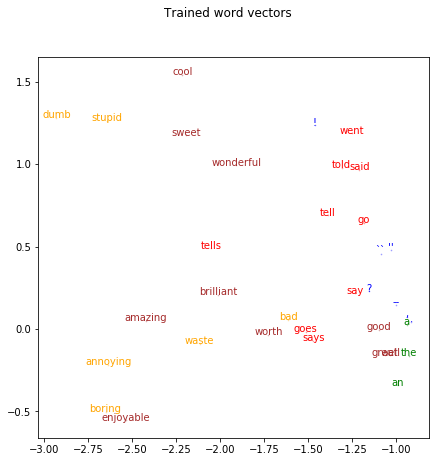

In [18]:
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt
def visualize_vectors(input_vectors, output_vectors, title=''):
    full_vectors = torch.cat((input_vectors, output_vectors), 0)
    wordvec_embedding = PCA(n_components=2).fit_transform(full_vectors.detach().cpu())

    # Helpful words form CS244D example
    # http://cs224d.stanford.edu/assignment1/index.html
    visualize_words = {'green': ["the", "a", "an"], 
                      'blue': [",", ".", "?", "!", "``", "''", "--"], 
                      'brown': ["good", "great", "cool", "brilliant", "wonderful", 
                              "well", "amazing", "worth", "sweet", "enjoyable"],
                      'orange': ["boring", "bad", "waste", "dumb", "annoying", "stupid"],
                      'red': ['tell', 'told', 'said', 'say', 'says', 'tells', 'goes', 'go', 'went']
                     }

    plt.figure(figsize=(7,7))
    plt.suptitle(title)
    for color, words in visualize_words.items():
        points = np.array([wordvec_embedding[StandfordData.index_by_token[w]] for w in words])
        for i, word in enumerate(words):
            plt.text(points[i, 0], points[i, 1], word, color=color,horizontalalignment='center')
        plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.3, s=0.5)

visualize_vectors(trained_input_vectors, trained_output_vectors, "Trained word vectors")

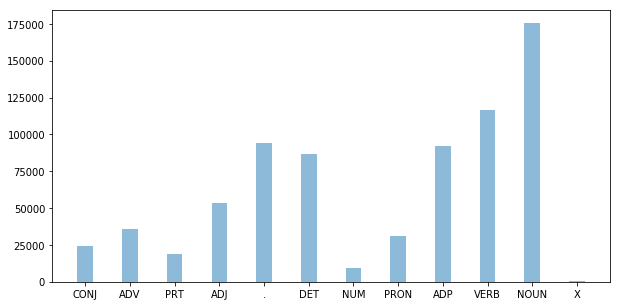

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

tag_distribution = Counter(tag for sample in train_data for _, tag in sample)
tag_distribution = [tag_distribution[tag] for tag in tags]

plt.figure(figsize=(10, 5))

bar_width = 0.35
plt.bar(np.arange(len(tags)), tag_distribution, bar_width, align='center', alpha=0.5)
plt.xticks(np.arange(len(tags)), tags)
    
plt.show()

## Бейзлайн

Какой самый простой теггер можно придумать? Давайте просто запоминать, какие теги самые вероятные для слова (или для последовательности):

![tag-context](https://www.nltk.org/images/tag-context.png)  
*From [Categorizing and Tagging Words, nltk](https://www.nltk.org/book/ch05.html)*

На картинке показано, что для предсказания $t_n$ используются два предыдущих предсказанных тега + текущее слово. По корпусу считаются вероятность для $P(t_n| w_n, t_{n-1}, t_{n-2})$, выбирается тег с максимальной вероятностью.

Более аккуратно такая идея реализована в Hidden Markov Models: по тренировочному корпусу вычисляются вероятности $P(w_n| t_n), P(t_n|t_{n-1}, t_{n-2})$ и максимизируется их произведение.

Простейший вариант - униграммная модель, учитывающая только слово:

In [0]:
import nltk

default_tagger = nltk.DefaultTagger('NN')

unigram_tagger = nltk.UnigramTagger(train_data, backoff=default_tagger)
print('Accuracy of unigram tagger = {:.2%}'.format(unigram_tagger.evaluate(test_data)))

Accuracy of unigram tagger = 92.62%


Добавим вероятности переходов:

In [0]:
bigram_tagger = nltk.BigramTagger(train_data, backoff=unigram_tagger)
print('Accuracy of bigram tagger = {:.2%}'.format(bigram_tagger.evaluate(test_data)))

Accuracy of bigram tagger = 93.42%


Обратите внимание, что `backoff` важен:

In [0]:
trigram_tagger = nltk.TrigramTagger(train_data)
print('Accuracy of trigram tagger = {:.2%}'.format(trigram_tagger.evaluate(test_data)))

Accuracy of trigram tagger = 23.33%


## Увеличиваем контекст с рекуррентными сетями

Униграмная модель работает на удивление хорошо, но мы же собрались учить сеточки.

Омонимия - основная причина, почему униграмная модель плоха:  
*“he cashed a check at the **bank**”*  
vs  
*“he sat on the **bank** of the river”*

Поэтому нам очень полезно учитывать контекст при предсказании тега.

Воспользуемся LSTM - он умеет работать с контекстом очень даже хорошо:

![](https://image.ibb.co/kgmoff/Baseline-Tagger.png)

Синим показано выделение фичей из слова, LSTM оранжевенький - он строит эмбеддинги слов с учетом контекста, а дальше зелененькая логистическая регрессия делает предсказания тегов.

In [0]:
def convert_data(data, word2ind, tag2ind):
    X = [[word2ind.get(word, 0) for word, _ in sample] for sample in data]
    y = [[tag2ind[tag] for _, tag in sample] for sample in data]
    
    return X, y

X_train, y_train = convert_data(train_data, word2ind, tag2ind)
X_val, y_val = convert_data(val_data, word2ind, tag2ind)
X_test, y_test = convert_data(test_data, word2ind, tag2ind)

In [0]:
def iterate_batches(data, batch_size):
    X, y = data
    n_samples = len(X)

    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_indices = indices[start:end]
        
        max_sent_len = max(len(X[ind]) for ind in batch_indices)
        X_batch = np.zeros((max_sent_len, len(batch_indices)))
        y_batch = np.zeros((max_sent_len, len(batch_indices)))
        
        for batch_ind, sample_ind in enumerate(batch_indices):
            X_batch[:len(X[sample_ind]), batch_ind] = X[sample_ind]
            y_batch[:len(y[sample_ind]), batch_ind] = y[sample_ind]
            
        yield X_batch, y_batch

In [22]:
X_batch, y_batch = next(iterate_batches((X_train, y_train), 4))

X_batch.shape, y_batch.shape

((31, 4), (31, 4))

**Задание** Реализуйте `LSTMTagger`:

In [0]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, embeddings, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super(LSTMTagger, self).__init__()
        self.tagset_size = tagset_size
        self.word_embeddings = nn.Embedding(vocab_size, word_emb_dim).from_pretrained(embeddings)
        self.lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, lstm_layers_count, bidirectional = True)
        self.linear = nn.Linear(2*lstm_hidden_dim, tagset_size)
    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.linear(lstm_out)
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

**Задание** Научитесь считать accuracy и loss (а заодно проверьте, что модель работает)

In [30]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind),
    embeddings = torch.tensor(embeddings).to(device).type(FloatTensor)
).to(device)

X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)

logits = model(X_batch)
predictions = torch.argmax(logits, 2)
all_words = int(torch.sum(y_batch != 0))
print(all_words)
accuracy = float(torch.sum((abs(predictions - y_batch) == 0) * (y_batch != 0)))/ all_words
print(accuracy)
print(logits.shape, y_batch.shape)
print(y_batch)

71
0.07042253521126761
torch.Size([31, 4, 13]) torch.Size([31, 4])
tensor([[ 6,  2, 11, 11],
        [11,  5, 10, 11],
        [ 9,  8,  6,  9],
        [ 6, 10,  4,  6],
        [11, 10, 11, 11],
        [ 9,  2,  3,  5],
        [ 6, 10, 10,  0],
        [11,  9,  3,  0],
        [ 9,  6,  5,  0],
        [ 6, 10,  1,  0],
        [11,  1,  8,  0],
        [ 2, 10, 10,  0],
        [10, 11,  2,  0],
        [ 4,  9,  5,  0],
        [11, 11,  0,  0],
        [ 9, 10,  0,  0],
        [11,  6,  0,  0],
        [ 1,  4,  0,  0],
        [11, 11,  0,  0],
        [ 5, 11,  0,  0],
        [ 0,  5,  0,  0],
        [ 0,  9,  0,  0],
        [ 0,  6,  0,  0],
        [ 0, 10,  0,  0],
        [ 0, 11,  0,  0],
        [ 0, 10,  0,  0],
        [ 0,  9,  0,  0],
        [ 0,  6,  0,  0],
        [ 0,  4,  0,  0],
        [ 0, 11,  0,  0],
        [ 0,  5,  0,  0]], device='cuda:0')


In [31]:
criterion = nn.CrossEntropyLoss(ignore_index = 0).to(device)
print(criterion(logits.view(-1, model.tagset_size), y_batch.flatten()))

tensor(2.5699, device='cuda:0', grad_fn=<NllLossBackward>)


**Задание** Вставьте эти вычисление в функцию:

In [0]:
import math
from tqdm import tqdm


def do_epoch(model, criterion, data, batch_size, optimizer=None, name=None):
    epoch_loss = 0
    correct_count = 0
    sum_count = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = math.ceil(len(data[0]) / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
                X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
                logits = model(X_batch)
                predictions = torch.argmax(logits, 2)

                loss = criterion(logits.view(-1, model.tagset_size), y_batch.flatten())

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                cur_correct_count, cur_sum_count = float(torch.sum(\
                (predictions == y_batch) * (y_batch != 0))), int(torch.sum(y_batch != 0).item())

                correct_count += cur_correct_count
                sum_count += cur_sum_count

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                    name, loss.item(), cur_correct_count / cur_sum_count)
                )
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                name, epoch_loss / batches_count, correct_count / sum_count)
            )

    return epoch_loss / batches_count, correct_count / sum_count


def fit(model, criterion, optimizer, scheduler, train_data, epochs_count=1, batch_size=32,
        val_data=None, val_batch_size=None):
        
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss, train_acc = do_epoch(model, criterion, train_data, batch_size, optimizer, name_prefix + 'Train:')
        
        if not val_data is None:
            val_loss, val_acc = do_epoch(model, criterion, val_data, val_batch_size, None, name_prefix + '  Val:')
        scheduler.step()

In [35]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind),
    embeddings = torch.tensor(embeddings).to(device).type(FloatTensor)
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index = 0).to(device)
#optimizer = optim.SGD(model.parameters(), lr=2., weight_decay=0)
optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=1)

fit(model, criterion, optimizer, scheduler, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 50] Train: Loss = 0.83857, Accuracy = 74.16%: 100%|██████████| 572/572 [00:10<00:00, 55.46it/s]
[1 / 50]   Val: Loss = 0.56974, Accuracy = 81.50%: 100%|██████████| 13/13 [00:00<00:00, 33.92it/s]
[2 / 50] Train: Loss = 0.46642, Accuracy = 84.75%: 100%|██████████| 572/572 [00:10<00:00, 56.06it/s]
[2 / 50]   Val: Loss = 0.43497, Accuracy = 85.62%: 100%|██████████| 13/13 [00:00<00:00, 32.41it/s]
[3 / 50] Train: Loss = 0.37916, Accuracy = 87.60%: 100%|██████████| 572/572 [00:10<00:00, 56.09it/s]
[3 / 50]   Val: Loss = 0.37773, Accuracy = 87.65%: 100%|██████████| 13/13 [00:00<00:00, 33.08it/s]
[4 / 50] Train: Loss = 0.33222, Accuracy = 89.19%: 100%|██████████| 572/572 [00:10<00:00, 54.73it/s]
[4 / 50]   Val: Loss = 0.33849, Accuracy = 88.84%: 100%|██████████| 13/13 [00:00<00:00, 33.68it/s]
[5 / 50] Train: Loss = 0.30262, Accuracy = 90.19%: 100%|██████████| 572/572 [00:10<00:00, 56.16it/s]
[5 / 50]   Val: Loss = 0.31346, Accuracy = 89.65%: 100%|██████████| 13/13 [00:00<00:00, 31.93it/s]


In [39]:
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay=1e-4)
fit(model, criterion, optimizer, scheduler, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 50] Train: Loss = 0.12709, Accuracy = 96.35%: 100%|██████████| 572/572 [00:10<00:00, 55.55it/s]
[1 / 50]   Val: Loss = 0.17997, Accuracy = 94.24%: 100%|██████████| 13/13 [00:00<00:00, 34.13it/s]
[2 / 50] Train: Loss = 0.12460, Accuracy = 96.43%: 100%|██████████| 572/572 [00:10<00:00, 56.75it/s]
[2 / 50]   Val: Loss = 0.18151, Accuracy = 94.18%: 100%|██████████| 13/13 [00:00<00:00, 33.07it/s]
[3 / 50] Train: Loss = 0.12343, Accuracy = 96.45%: 100%|██████████| 572/572 [00:09<00:00, 57.20it/s]
[3 / 50]   Val: Loss = 0.18108, Accuracy = 94.17%: 100%|██████████| 13/13 [00:00<00:00, 33.98it/s]
[4 / 50] Train: Loss = 0.12417, Accuracy = 96.46%: 100%|██████████| 572/572 [00:10<00:00, 56.33it/s]
[4 / 50]   Val: Loss = 0.18224, Accuracy = 94.09%: 100%|██████████| 13/13 [00:00<00:00, 33.32it/s]
[5 / 50] Train: Loss = 0.12352, Accuracy = 96.46%: 100%|██████████| 572/572 [00:10<00:00, 56.97it/s]
[5 / 50]   Val: Loss = 0.18294, Accuracy = 94.07%: 100%|██████████| 13/13 [00:00<00:00, 32.74it/s]


### Masking

**Задание** Проверьте себя - не считаете ли вы потери и accuracy на паддингах - очень легко получить высокое качество за счет этого.

У функции потерь есть параметр `ignore_index`, для таких целей. Для accuracy нужно использовать маскинг - умножение на маску из нулей и единиц, где нули на позициях паддингов (а потом усреднение по ненулевым позициям в маске).

**Задание** Посчитайте качество модели на тесте. Ожидается результат лучше бейзлайна!

In [40]:
test_loss, test_acc = do_epoch(model, criterion, data = (X_test, y_test), batch_size = 64)

      Loss = 0.19496, Accuracy = 93.84%: 100%|██████████| 224/224 [00:02<00:00, 98.12it/s]


In [41]:
print(test_loss, test_acc)

0.1949646504861968 0.9383686383056368


### Bidirectional LSTM

Благодаря BiLSTM можно использовать сразу оба контеста при предсказании тега слова. Т.е. для каждого токена $w_i$ forward LSTM будет выдавать представление $\mathbf{f_i} \sim (w_1, \ldots, w_i)$ - построенное по всему левому контексту - и $\mathbf{b_i} \sim (w_n, \ldots, w_i)$ - представление правого контекста. Их конкатенация автоматически захватит весь доступный контекст слова: $\mathbf{h_i} = [\mathbf{f_i}, \mathbf{b_i}] \sim (w_1, \ldots, w_n)$.

![BiLSTM](https://www.researchgate.net/profile/Wang_Ling/publication/280912217/figure/fig2/AS:391505383575555@1470353565299/Illustration-of-our-neural-network-for-POS-tagging.png)  
*From [Finding Function in Form: Compositional Character Models for Open Vocabulary Word Representation](https://arxiv.org/abs/1508.02096)*

**Задание** Добавьте Bidirectional LSTM.

### Предобученные эмбеддинги

Мы знаем, какая клёвая вещь - предобученные эмбеддинги. При текущем размере обучающей выборки еще можно было учить их и с нуля - с меньшей было бы совсем плохо.

Поэтому стандартный пайплайн - скачать эмбеддинги, засунуть их в сеточку. Запустим его:

In [42]:
import gensim.downloader as api

w2v_model = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [43]:
w2v_model.most_similar("cat")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('dog', 0.8798074722290039),
 ('rabbit', 0.7424426674842834),
 ('cats', 0.7323004007339478),
 ('monkey', 0.7288709878921509),
 ('pet', 0.7190139889717102),
 ('dogs', 0.7163872718811035),
 ('mouse', 0.6915250420570374),
 ('puppy', 0.6800068020820618),
 ('rat', 0.6641027331352234),
 ('spider', 0.6501135230064392)]

In [44]:
w2v_model.vectors.shape

(400000, 100)

Построим подматрицу для слов из нашей тренировочной выборки:

In [45]:
known_count = 0
for word, ind in word2ind.items():
    word = word.lower()
    if word in w2v_model.vocab:
        embeddings[ind] = w2v_model.get_vector(word)
        known_count += 1
        
print('Know {} out of {} word embeddings'.format(known_count, len(word2ind)))

Know 38736 out of 45441 word embeddings


**Задание** Сделайте модель с предобученной матрицей. Используйте `nn.Embedding.from_pretrained`.

In [47]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind),
    embeddings = torch.tensor(embeddings).to(device).type(FloatTensor)
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=1)

fit(model, criterion, optimizer, scheduler, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 50] Train: Loss = 0.49325, Accuracy = 86.60%: 100%|██████████| 572/572 [00:10<00:00, 55.89it/s]
[1 / 50]   Val: Loss = 0.22910, Accuracy = 93.10%: 100%|██████████| 13/13 [00:00<00:00, 33.72it/s]
[2 / 50] Train: Loss = 0.17906, Accuracy = 94.60%: 100%|██████████| 572/572 [00:10<00:00, 56.21it/s]
[2 / 50]   Val: Loss = 0.16406, Accuracy = 95.06%: 100%|██████████| 13/13 [00:00<00:00, 32.75it/s]
[3 / 50] Train: Loss = 0.12902, Accuracy = 96.07%: 100%|██████████| 572/572 [00:10<00:00, 56.11it/s]
[3 / 50]   Val: Loss = 0.13553, Accuracy = 95.86%: 100%|██████████| 13/13 [00:00<00:00, 32.53it/s]
[4 / 50] Train: Loss = 0.10522, Accuracy = 96.80%: 100%|██████████| 572/572 [00:10<00:00, 56.46it/s]
[4 / 50]   Val: Loss = 0.12312, Accuracy = 96.18%: 100%|██████████| 13/13 [00:00<00:00, 34.29it/s]
[5 / 50] Train: Loss = 0.09146, Accuracy = 97.18%: 100%|██████████| 572/572 [00:10<00:00, 56.26it/s]
[5 / 50]   Val: Loss = 0.11586, Accuracy = 96.52%: 100%|██████████| 13/13 [00:00<00:00, 34.01it/s]


**Задание** Оцените качество модели на тестовой выборке. Обратите внимание, вовсе не обязательно ограничиваться векторами из урезанной матрицы - вполне могут найтись слова в тесте, которых не было в трейне и для которых есть эмбеддинги.

Добейтесь качества лучше прошлых моделей.

In [48]:
test_loss, test_acc = do_epoch(model, criterion, data = (X_test, y_test), batch_size = 64)

      Loss = 0.20280, Accuracy = 96.63%: 100%|██████████| 224/224 [00:02<00:00, 97.81it/s]
